In [9]:
import json
import timeit
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt
import urllib
from zipfile import ZipFile
from pathlib import Path

AS = CP.AbstractState('HEOS','Water')

Caveats:
* When superancillaries are enabled, the "critical point" is the numerical one that is obtained by enforcing $\left(\frac{\partial p}{\partial \rho}\right)_T = \left(\frac{\partial^2 p}{\partial \rho^2}\right)_T = 0$, rather than the one reported by the EOS developers. This is because the superancillaries are developed to try to fix the critical region as well as possible. The differences can be sometimes not too small: [An Analysis of the Critical Region of Multiparameter Equations of State](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=WNn0e_4AAAAJ&sortby=pubdate&citation_for_view=WNn0e_4AAAAJ:1qzjygNMrQYC)

In [10]:
for superanc in [False, True]:
    CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, superanc)
    print(superanc, AS.T_critical())

False 647.096
True 647.0959999999873


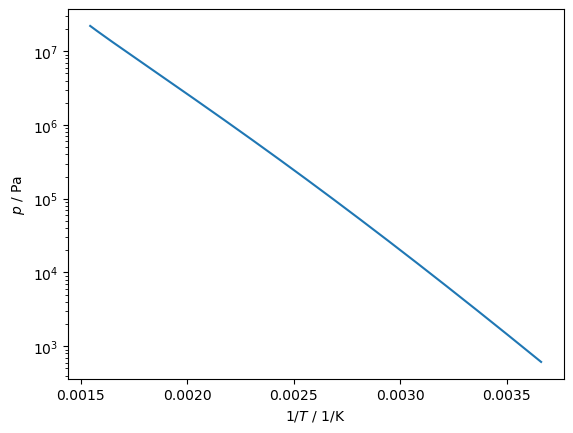

In [11]:
# The JSON data for the expansions can be accessed from CoolProp
jSuper = json.loads(CP.get_fluid_param_string("WATER", "JSON"))[0]["EOS"][0]["SUPERANCILLARY"]
SA = CP.SuperAncillary(json.dumps(jSuper))

AS = CP.AbstractState('HEOS','Water')
Tt = AS.Ttriple()
Tc = AS.T_critical()

Ts = np.linspace(Tt, 647.0959999999873, 5*10**5)
ps = np.zeros_like(Ts)
SA.eval_sat_many(Ts, 'P', 0, ps)
plt.plot(1/Ts, ps)
plt.yscale('log'); plt.gca().set(xlabel='$1/T$ / 1/K', ylabel='$p$ / Pa');

In [12]:
# At the lower level, calling with a buffer of points
tic = timeit.default_timer()
SA.eval_sat_many(Ts, 'P', 0, ps)
toc = timeit.default_timer()
print((toc-tic)/len(Ts)*1e6, 'μs/call')

0.031082581728696823 μs/call


In [13]:
# With superancillaries enabled; three functions are evaluated
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, False)
QT_INPUTS = CP.QT_INPUTS
tic = timeit.default_timer()
for T_ in Ts:
    AS.update(QT_INPUTS, 0, T_)
toc = timeit.default_timer()
print((toc-tic)/len(Ts)*1e6, 'μs/call')

26.667643168009818 μs/call


In [14]:
# With superancillaries enabled; three functions are evaluated, plus any Python <-> C overhead
CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, True)
QT_INPUTS = CP.QT_INPUTS
tic = timeit.default_timer()
for T_ in Ts:
    AS.update(QT_INPUTS, 0, T_)
toc = timeit.default_timer()
print((toc-tic)/len(Ts)*1e6, 'μs/call')

0.3387536657974124 μs/call


In [18]:
outputversion = '2025.03.30-v2'
if not Path(f'{outputversion}.zip').exists():
    print('Downloading the chebyshev output file to ', Path('.').absolute())
    urllib.request.urlretrieve(f'https://github.com/CoolProp/fastchebpure/archive/refs/tags/{outputversion}.zip', f'{outputversion}.zip')

    with ZipFile(f'{outputversion}.zip') as z:
        print(Path(f'{outputversion}.zip').parent.absolute())
        z.extractall(Path(f'{outputversion}.zip').parent.absolute())

    with (Path('.') / f'fastchebpure-{outputversion}' / '.gitignore').open('w') as fp:
        fp.write("*")

outputcheck = (Path('.') / f'fastchebpure-{outputversion}' / 'outputcheck').absolute()
assert outputcheck.exists()

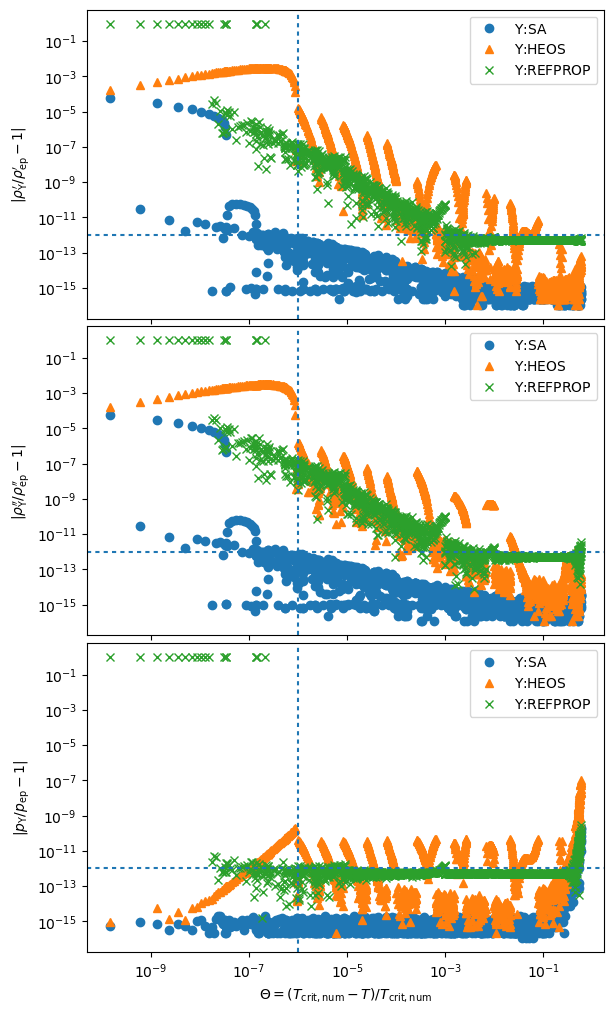

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP

fluid = 'Water'

CP.set_config_bool(CP.ENABLE_SUPERANCILLARIES, False)

from pathlib import Path
CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, str(Path('~/REFPROP10').expanduser()))

AS = CP.AbstractState('HEOS', f"{fluid}")
jSuper = json.loads(CP.get_fluid_param_string(f"{fluid}", "JSON"))[0]['EOS'][0]['SUPERANCILLARY']
superanc = CP.SuperAncillary(json.dumps(jSuper))
RPname = AS.fluid_param_string("REFPROP_name")

# Load extended precision calcs from the release on github
chk = json.load(open(f'{outputcheck}/{fluid}_check.json'))
df = pd.DataFrame(chk['data'])
# df.info() # uncomment to see what fields are available

Tcrit_num = AS.get_fluid_parameter_double(0, "SUPERANC::Tcrit_num")
T = df['T / K'].to_numpy()
Theta = (Tcrit_num-T)/Tcrit_num

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6,10))


plt.sca(axes[0])
rhoL_anc = np.zeros_like(T)
superanc.eval_sat_many(T, 'D', 0, rhoL_anc)
err = np.abs(df["rho'(mp) / mol/m^3"]/rhoL_anc-1)
plt.plot(Theta, err, 'o', label=r'$\Upsilon$:SA')

errCP = np.abs(df["rho'(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 0, f'HEOS::{fluid}')-1)
plt.plot(Theta, errCP, '^', label=r'$\Upsilon$:HEOS')

try:
    errRP = np.abs(df["rho'(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 0, f'REFPROP::{RPname}')-1)
    plt.plot(Theta, errRP, 'x', label=r'$\Upsilon$:REFPROP')
except BaseException as BE:
    print(BE)

plt.legend(loc='best')
plt.ylabel(r"$|\rho_{{\rm \Upsilon}}'/\rho_{{\rm ep}}'-1|$")
plt.yscale('log')



plt.sca(axes[1])
rhoV_anc = np.zeros_like(T)
superanc.eval_sat_many(T, 'D', 1, rhoV_anc)
err = np.abs(df["rho''(mp) / mol/m^3"]/rhoV_anc-1)
plt.plot(Theta, err, 'o', label=r'$\Upsilon$:SA')

errCP = np.abs(df["rho''(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 1, f'HEOS::{fluid}')-1)
plt.plot(Theta, errCP, '^', label=r'$\Upsilon$:HEOS')

try:
    errRP = np.abs(df["rho''(mp) / mol/m^3"]/CP.PropsSI('Dmolar', 'T', T, 'Q', 1, f'REFPROP::{RPname}')-1)
    plt.plot(Theta, errRP, 'x', label=r'$\Upsilon$:REFPROP')
except BaseException as BE:
    print(BE)

plt.legend(loc='best')
plt.ylabel(r"$|\rho_{{\rm \Upsilon}}''/\rho_{{\rm ep}}''-1|$")
plt.yscale('log')



plt.sca(axes[2])
p_anc = np.zeros_like(T)
superanc.eval_sat_many(T, 'P', 1, p_anc)
err = np.abs(df["p(mp) / Pa"]/p_anc-1)
plt.plot(Theta, err, 'o', label=r'$\Upsilon$:SA')

errCP = np.abs(df["p(mp) / Pa"]/CP.PropsSI('P', 'T', T, 'Q', 1, f'HEOS::{fluid}')-1)
plt.plot(Theta, errCP, '^', label=r'$\Upsilon$:HEOS')

try:
    errRP = np.abs(df["p(mp) / Pa"]/CP.PropsSI('P', 'T', T, 'Q', 1, f'REFPROP::{RPname}')-1)
    plt.plot(Theta, errRP, 'x', label=r'$\Upsilon$:REFPROP')
except BaseException as BE:
    print(BE)
plt.legend(loc='best')

# print(CP.PropsSI('gas_constant', 'T', T[0], 'Q', 1, f'HEOS::{fluid}'))
# print(CP.PropsSI('gas_constant', 'T', T[0], 'Q', 1, f'REFPROP::{fluid}'))

plt.ylabel(r"$|p_{{\rm \Upsilon}}/p_{{\rm ep}}-1|$")
plt.yscale('log')

plt.sca(axes[2])
plt.xlabel(r'$\Theta=(T_{{\rm crit,num}}-T)/T_{{\rm crit,num}}$')
plt.xscale('log')

for ax in axes:
    ax.axhline(1e-12, dashes=[2,2])
    ax.axvline(1e-6, dashes=[2,2])

plt.tight_layout(pad=0.2)
plt.savefig(f'{fluid}.png', dpi = 30)
plt.savefig(f'{fluid}.pdf')
plt.show()